# ContinuousDP: Stochastic Optimal Growth Model

In [1]:
using QuantEcon
using BasisMatrices
using ContinuousDPs
using PyPlot

In [2]:
alpha = 0.4
beta = 0.96
mu = 0
sigma = 0.1;

In [3]:
f(s, x) = log(x)
g(s, x, e) = (s - x)^alpha * e;

In [4]:
shock_size = 250
shocks = exp.(mu + sigma * randn(shock_size))
weights = fill(1/shock_size, shock_size);

In [5]:
grid_max = 4.
n = 30
s_min, s_max = 1e-5, grid_max
basis = Basis(ChebParams(n, s_min, s_max))

1 dimensional Basis on the hypercube formed by (1.0e-5,) × (4.0,).
Basis families are Cheb


In [6]:
x_lb(s) = s_min
x_ub(s) = s;

In [7]:
ab = alpha * beta
c1 = log(1 - ab) / (1 - beta)
c2 = (mu + alpha * log(ab)) / (1 - alpha)
c3 = 1 / (1 - beta)
c4 = 1 / (1 - ab)

# True optimal policy
c_star(y) = (1 - alpha * beta) * y

# True value function
v_star(y) = c1 + c2 * (c3 - c4) + c4 * log(y);

In [8]:
cdp = ContinuousDP(f, g, beta, shocks, weights, x_lb, x_ub, basis);

In [9]:
@code_warntype ContinuousDP(f, g, beta, shocks, weights, x_lb, x_ub, basis)

Variables:
  #self# <optimized out>
  f <optimized out>
  g <optimized out>
  discount::Float64
  shocks::Array{Float64,1}
  weights::Array{Float64,1}
  x_lb <optimized out>
  x_ub <optimized out>
  basis::BasisMatrices.Basis{1,Tuple{BasisMatrices.ChebParams{Float64}}}
  interp::ContinuousDPs.Interp{1,Array{Float64,1},Array{Float64,2},Base.LinAlg.LU{Float64,Array{Float64,2}}}
  cdp::ContinuousDPs.ContinuousDP{1,Array{Float64,1},Array{Float64,1}}

Body:
  begin 
      interp::ContinuousDPs.Interp{1,Array{Float64,1},Array{Float64,2},Base.LinAlg.LU{Float64,Array{Float64,2}}} = $(Expr(:invoke, MethodInstance for ContinuousDPs.Interp(::BasisMatrices.Basis{1,Tuple{BasisMatrices.ChebParams{Float64}}}), :(ContinuousDPs.Interp), :(basis))) # line 59:
      cdp::ContinuousDPs.ContinuousDP{1,Array{Float64,1},Array{Float64,1}} = $(Expr(:new, ContinuousDPs.ContinuousDP{1,Array{Float64,1},Array{Float64,1}}, :($(QuoteNode(f))), :($(QuoteNode(g))), :(discount), :(shocks), :(weights), :($(QuoteNode(x_l

## First test

In [10]:
C_star = cdp.interp.Phi \ v_star.(cdp.interp.S)
Tv = Array{Float64}(cdp.interp.length)
C = copy(C_star)
bellman_operator!(cdp, C, Tv);

In [11]:
@code_warntype bellman_operator!(cdp, C, Tv)

Variables:
  #self# <optimized out>
  cdp::ContinuousDPs.ContinuousDP{1,Array{Float64,1},Array{Float64,1}}
  C::Array{Float64,1}
  Tv@_4::Array{Float64,1}
  Tv@_5::Array{Float64,1}

Body:
  begin 
      Tv@_5::Array{Float64,1} = Tv@_4::Array{Float64,1}
      Tv@_5::Array{Float64,1} = $(Expr(:invoke, MethodInstance for s_wise_max!(::ContinuousDPs.ContinuousDP{1,Array{Float64,1},Array{Float64,1}}, ::Array{Float64,1}, ::Array{Float64,1}, ::Array{Float64,1}), :(ContinuousDPs.s_wise_max!), :(cdp), :((Core.getfield)((Core.getfield)(cdp, :interp)::ContinuousDPs.Interp{1,Array{Float64,1},TM,TL} where TL<:Factorization where TM<:(AbstractArray{T,2} where T), :S)::Array{Float64,1}), :(C), :(Tv@_5))) # line 198:
      (ContinuousDPs.A_ldiv_B!)(C::Array{Float64,1}, (Core.getfield)((Core.getfield)(cdp::ContinuousDPs.ContinuousDP{1,Array{Float64,1},Array{Float64,1}}, :interp)::ContinuousDPs.Interp{1,Array{Float64,1},TM,TL} where TL<:Factorization where TM<:(AbstractArray{T,2} where T), :Phi_lu)::Fac

In [12]:
grid_size = 200
grid_y = collect(linspace(s_min, s_max, grid_size))
V_approx = funeval(C, cdp.interp.basis, grid_y);

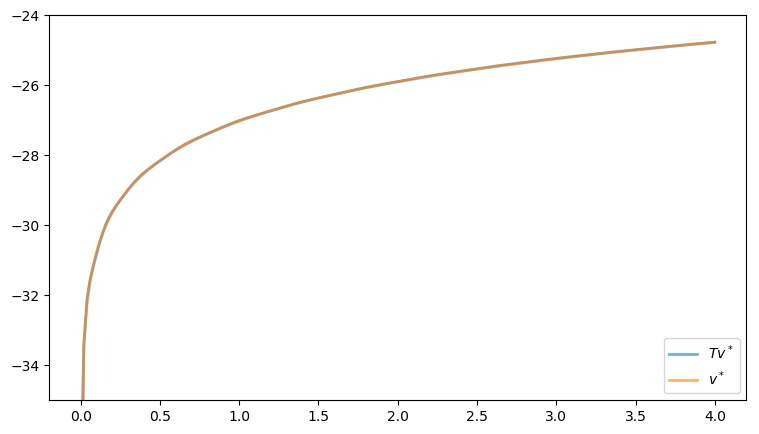

In [13]:
fig, ax = subplots(figsize=(9, 5))
ax[:set_ylim](-35, -24)
ax[:plot](grid_y, V_approx, lw=2, alpha=0.6, label=L"$Tv^*$")
ax[:plot](grid_y, v_star.(grid_y), lw=2, alpha=0.6, label=L"$v^*$")
ax[:legend](loc="lower right")
show()

In [14]:
@time bellman_operator!(cdp, C, Tv)
@time bellman_operator!(cdp, C, Tv)
@time bellman_operator!(cdp, C, Tv);

  0.497321 seconds (6.91 M allocations: 381.761 MiB, 12.03% gc time)
  0.483125 seconds (6.58 M allocations: 363.577 MiB, 10.40% gc time)
  0.427293 seconds (6.25 M allocations: 345.398 MiB, 9.29% gc time)


In [15]:
s = 2.
@code_warntype ContinuousDPs._s_wise_max(cdp, s, C)

Variables:
  #self# <optimized out>
  cdp::ContinuousDPs.ContinuousDP{1,Array{Float64,1},Array{Float64,1}}
  s::Float64
  C::Array{Float64,1}
  objective::ContinuousDPs.#objective#3{ContinuousDPs.ContinuousDP{1,Array{Float64,1},Array{Float64,1}},Float64,Array{Float64,1}}
  res::Any
  v::Float64
  x::Float64

Body:
  begin 
      objective::ContinuousDPs.#objective#3{ContinuousDPs.ContinuousDP{1,Array{Float64,1},Array{Float64,1}},Float64,Array{Float64,1}} = $(Expr(:new, ContinuousDPs.#objective#3{ContinuousDPs.ContinuousDP{1,Array{Float64,1},Array{Float64,1}},Float64,Array{Float64,1}}, :(cdp), :(s), :(C))) # line 160:
      res::Any = (Optim.optimize)(objective::ContinuousDPs.#objective#3{ContinuousDPs.ContinuousDP{1,Array{Float64,1},Array{Float64,1}},Float64,Array{Float64,1}}, ((Core.getfield)(cdp::ContinuousDPs.ContinuousDP{1,Array{Float64,1},Array{Float64,1}}, :x_lb)::F)(s::Float64)::Any, ((Core.getfield)(cdp::ContinuousDPs.ContinuousDP{1,Array{Float64,1},Array{Float64,1}}, :x_ub)::F

In [16]:
@time ContinuousDPs._s_wise_max(cdp, s, C)
@time ContinuousDPs._s_wise_max(cdp, s, C)
@time ContinuousDPs._s_wise_max(cdp, s, C);

  0.010893 seconds (157.27 k allocations: 8.694 MiB)
  0.010368 seconds (157.27 k allocations: 8.694 MiB)
  0.014511 seconds (157.27 k allocations: 8.694 MiB, 28.38% gc time)


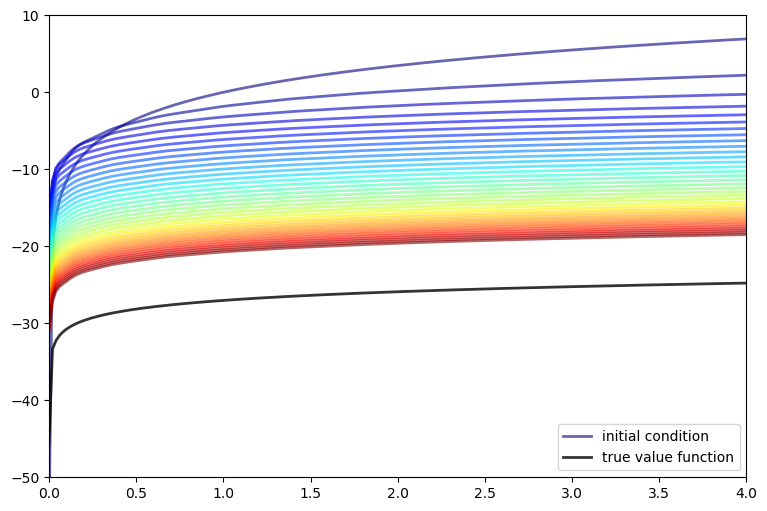

In [17]:
v_init_func(s) = 5 * log(s)
w = v_init_func.(grid_y)
n = 35

fig, ax = subplots(figsize=(9, 6))
ax[:set_ylim](-50, 10)
ax[:set_xlim](minimum(grid_y), maximum(grid_y))
lb = "initial condition"
jet = ColorMap("jet")
ax[:plot](grid_y, w, color=jet(0), lw=2, alpha=0.6, label=lb)

S = cdp.interp.S
V = v_init_func.(S)
for i in 1:n
    C = cdp.interp.Phi \ V
    bellman_operator!(cdp, C, V)
    w = funeval(C, cdp.interp.basis, grid_y)
    ax[:plot](grid_y, w, color=jet(i / n), lw=2, alpha=0.6)
end

lb = "true value function"
ax[:plot](grid_y, v_star.(grid_y), "k-", lw=2, alpha=0.8, label=lb)
ax[:legend](loc="lower right")

show()

## Solve by policy iteration

In [18]:
res = solve(cdp);

Compute iterate 6 with error 1.2079226507921703e-13
Converged in 6 steps


In [19]:
@code_warntype solve(cdp)

Variables:
  #self#::QuantEcon.#solve
  cdp::ContinuousDPs.ContinuousDP{1,Array{Float64,1},Array{Float64,1}}

Body:
  begin 
      return $(Expr(:invoke, MethodInstance for #solve#7(::Float64, ::Int64, ::Int64, ::Int64, ::Function, ::ContinuousDPs.ContinuousDP{1,Array{Float64,1},Array{Float64,1}}, ::Type{QuantEcon.PFI}), :(ContinuousDPs.#solve#7), :((Base.Math.sqrt_llvm)(2.220446049250313e-16)::Float64), 500, 2, 50, :(#self#), :(cdp), :(ContinuousDPs.PFI)))
  end::ContinuousDPs.CDPSolveResult{QuantEcon.PFI,1,Array{Float64,1},Array{Float64,1}}


In [20]:
@time res = solve(cdp)
@time res = solve(cdp)
@time res = solve(cdp);

Compute iterate 6 with error 1.2079226507921703e-13
Converged in 6 steps
  3.927570 seconds (55.98 M allocations: 3.054 GiB, 10.70% gc time)
Compute iterate 6 with error 1.2079226507921703e-13
Converged in 6 steps
  3.914640 seconds (55.98 M allocations: 3.054 GiB, 10.58% gc time)
Compute iterate 6 with error 1.2079226507921703e-13
Converged in 6 steps
  3.912367 seconds (55.98 M allocations: 3.054 GiB, 10.68% gc time)


In [21]:
set_eval_nodes!(res, grid_y);

In [22]:
@code_warntype set_eval_nodes!(res, grid_y)

Variables:
  #self# <optimized out>
  res::ContinuousDPs.CDPSolveResult{QuantEcon.PFI,1,Array{Float64,1},Array{Float64,1}}
  s_nodes_coord::Tuple{Array{Float64,1}}
  s_nodes::Array{Float64,1}

Body:
  begin 
      $(Expr(:inbounds, false))
      # meta: location /Users/oyama/.julia/v0.6/ContinuousDPs/src/cdp.jl set_eval_nodes! 107
      s_nodes::Array{Float64,1} = (Base.getfield)(s_nodes_coord::Tuple{Array{Float64,1}}, 1)::Array{Float64,1} # line 108:
      (Core.setfield!)(res::ContinuousDPs.CDPSolveResult{QuantEcon.PFI,1,Array{Float64,1},Array{Float64,1}}, :eval_nodes, s_nodes::Array{Float64,1})::Array{Float64,1} # line 109:
      (Core.setfield!)(res::ContinuousDPs.CDPSolveResult{QuantEcon.PFI,1,Array{Float64,1},Array{Float64,1}}, :eval_nodes_coord, s_nodes_coord::Tuple{Array{Float64,1}})::Tuple{Array{Float64,1}}
      # meta: pop location
      $(Expr(:inbounds, :pop))
      return $(Expr(:invoke, MethodInstance for evaluate!(::ContinuousDPs.CDPSolveResult{QuantEcon.PFI,1,Array{Flo

In [23]:
@time set_eval_nodes!(res, grid_y)
@time set_eval_nodes!(res, grid_y)
@time set_eval_nodes!(res, grid_y);

  2.988224 seconds (42.66 M allocations: 2.303 GiB, 10.88% gc time)
  2.970519 seconds (42.66 M allocations: 2.303 GiB, 10.79% gc time)
  2.961482 seconds (42.66 M allocations: 2.303 GiB, 10.79% gc time)


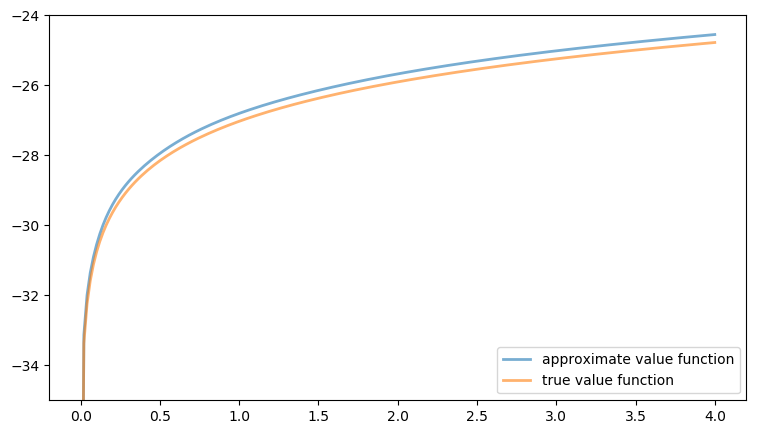

In [24]:
fig, ax = subplots(figsize=(9, 5))
ax[:set_ylim](-35, -24)
ax[:plot](grid_y, res.V, lw=2, alpha=0.6, label="approximate value function")
ax[:plot](grid_y, v_star.(grid_y), lw=2, alpha=0.6, label="true value function")
ax[:legend](loc="lower right")
show()

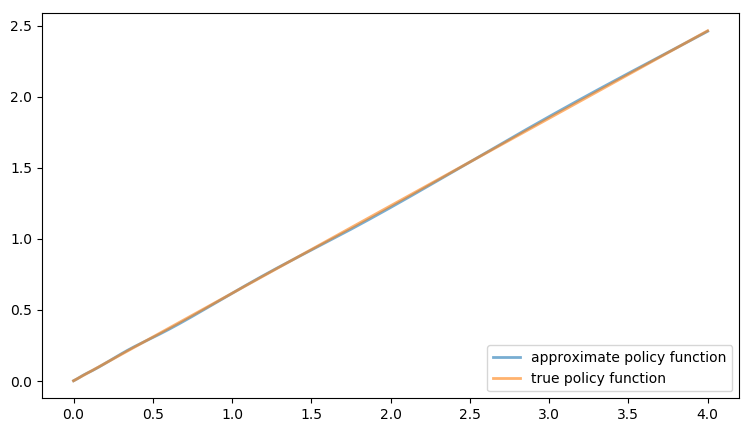

In [25]:
fig, ax = subplots(figsize=(9, 5))
ax[:plot](grid_y, res.X, lw=2, alpha=0.6, label="approximate policy function")
ax[:plot](grid_y, c_star.(grid_y), lw=2, alpha=0.6, label="true policy function")
ax[:legend](loc="lower right")
show()

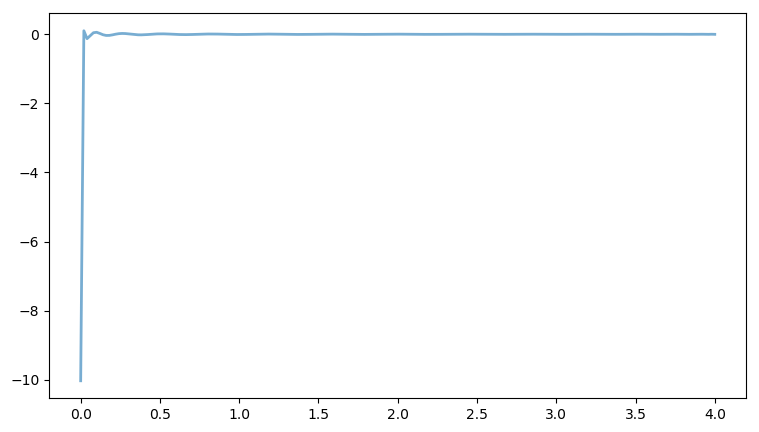

In [26]:
fig, ax = subplots(figsize=(9, 5))
ax[:plot](grid_y, res.resid, lw=2, alpha=0.6, label="residual")
show()

## Simulate the controlled Markov process

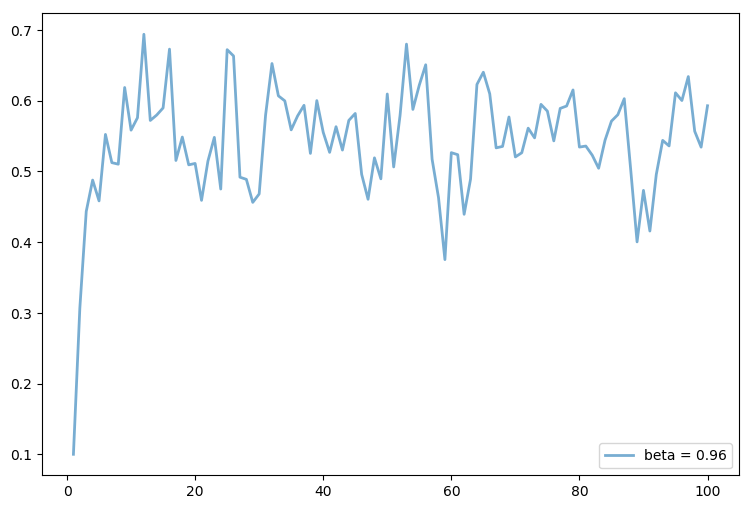

In [27]:
s_init = 0.1
ts_length = 100
y = simulate(res, s_init, ts_length)

fig, ax = subplots(figsize=(9, 6))
ax[:plot](1:ts_length, y, lw=2, alpha=0.6, label="beta = $(cdp.discount)" )
ax[:legend](loc="lower right")
show()

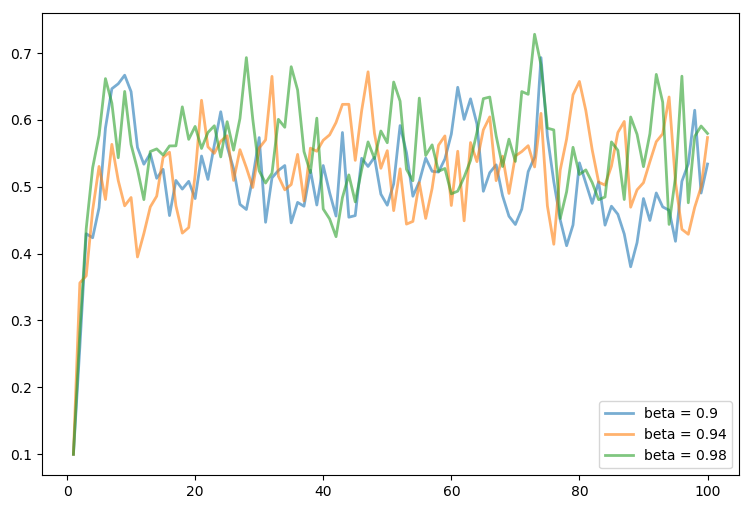

In [28]:
fig, ax = subplots(figsize=(9, 6))

for beta in (0.9, 0.94, 0.98)
    cdp.discount = beta
    res = solve(cdp, verbose=0)
    set_eval_nodes!(res, grid_y)
    y = simulate(res, s_init, ts_length)
    ax[:plot](1:ts_length, y, lw=2, alpha=0.6, label="beta = $(cdp.discount)" )
end

ax[:legend](loc="lower right")
show()

In [29]:
@code_warntype simulate!(MersenneTwister(0), Array{Float64}(ts_length), res, s_init)

Variables:
  #self# <optimized out>
  rng::MersenneTwister
  s_path::Array{Float64,1}
  res::ContinuousDPs.CDPSolveResult{QuantEcon.PFI,1,Array{Float64,1},Array{Float64,1}}
  s_init::Float64
  t@_6::Int64
  #temp#@_7::Int64
  s::Float64
  x@_9::Float64
  e::Float64
  t@_11::Int64
  #temp#@_12::Int64
  #10::ContinuousDPs.##10#11
  ts_length::Int64
  cdf::Array{Float64,1}
  r::Array{Float64,1}
  e_ind::Array{Int64,1}
  basis <optimized out>
  X_interp <optimized out>
  s_ind_front <optimized out>
  e_ind_tail <optimized out>
  bs::BasisMatrices.BasisMatrix{BasisMatrices.Tensor,SparseMatrixCSC{Float64,Int64}}
  x@_23::Array{Float64,1}
  c::Array{Float64,1}

Body:
  begin 
      NewvarNode(:(#10::ContinuousDPs.##10#11))
      NewvarNode(:(X_interp::Any))
      SSAValue(38) = (Base.arraysize)(s_path::Array{Float64,1}, 1)::Int64
      ts_length::Int64 = SSAValue(38) # line 335:
      SSAValue(15) = (Core.getfield)((Core.getfield)(res::ContinuousDPs.CDPSolveResult{QuantEcon.PFI,1,Array{Float6

      SSAValue(14) = ((Core.getfield)((Core.getfield)(res::ContinuousDPs.CDPSolveResult{QuantEcon.PFI,1,Array{Float64,1},Array{Float64,1}}, :cdp)::ContinuousDPs.ContinuousDP{1,Array{Float64,1},Array{Float64,1}}, :g)::F)(s::Float64, x@_9::Float64, e::Float64)::Any
      (Base.arrayset)(s_path::Array{Float64,1}, (Core.typeassert)((Base.convert)(Float64, SSAValue(14))::Any, Float64)::Float64, SSAValue(49))::Array{Float64,1}
      122: 
      goto 93
      124:  # line 355:
      return s_path::Array{Float64,1}
  end::Array{Float64,1}


In [30]:
@time simulate!(MersenneTwister(0), Array{Float64}(ts_length), res, s_init)
@time simulate!(MersenneTwister(0), Array{Float64}(ts_length), res, s_init)
@time simulate!(MersenneTwister(0), Array{Float64}(ts_length), res, s_init);

  0.000513 seconds (4.64 k allocations: 302.813 KiB)
  0.000456 seconds (4.64 k allocations: 302.813 KiB)
  0.000438 seconds (4.64 k allocations: 302.813 KiB)
